In [68]:
!pip install seaborn --upgrade

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 495.5 kB/s eta 0:00:01
   -------------------- ------------------- 153.6/294.9 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [31]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text

In [3]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [71]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [4]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [6]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [8]:

# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

# Function to extract features
def extract_features(audio_clips, sr):
    mfcc_features = []
    for sound in audio_clips:
        mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=13)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        mfcc_features.append(mfcc_scaled)
    return np.array(mfcc_features)

# Variables
fixed_length = 5 * 22050  # 5 seconds multiplied by sampling rate
sr = 22050  # Default sampling rate from librosa


# Load and process audio files
processed_audio = load_and_process_audio(file_paths, sr, fixed_length)

# Extract features
features = extract_features(processed_audio, sr)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)


In [9]:
# Initialize the model
clf_mfcc = RandomForestClassifier(random_state=42)

# Train the model
clf_mfcc.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_mfcc.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(f"Classification Report: {classification_report(y_test, y_pred, target_names=label_encoder.classes_)}\n")
tree_in_forest = clf_mfcc.estimators_[0]
tree_rules = export_text(tree_in_forest, feature_names=[f"feature_{i}" for i in range(all_features.shape[1])])
print("Rules of the first decision tree:\n", tree_rules)

Accuracy: 0.9013824884792627

Classification Report:               precision    recall  f1-score   support

    bewickii       0.91      0.89      0.90       193
  cardinalis       0.92      0.91      0.92       204
     melodia       0.87      0.92      0.89       243
 migratorius       0.90      0.96      0.93       207
 polyglottos       0.92      0.83      0.87       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085




The overall accuracy of the model is approximately 90.14%. Each bird species is evaluated on precision, recall, and F1-score, which are metrics indicating how well the model performs for each specific class. For instance, "Cardinalis cardinalis" has a precision of 0.92 and a recall of 0.91, resulting in an F1-score of 0.91, suggesting high accuracy and consistency in predicting this particular species. 

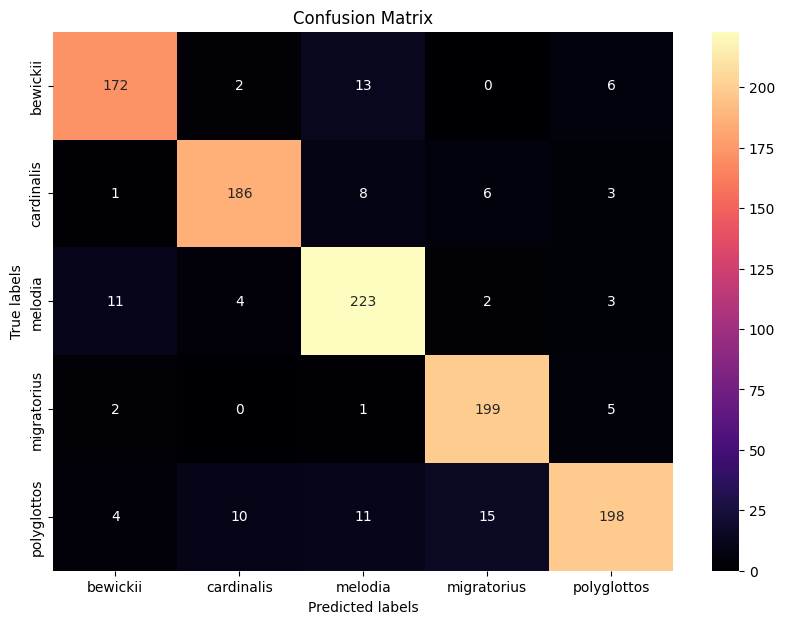

[[172   2  13   0   6]
 [  1 186   8   6   3]
 [ 11   4 223   2   3]
 [  2   0   1 199   5]
 [  4  10  11  15 198]]


In [10]:

cm_mfcc = confusion_matrix(y_test, y_pred)
# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mfcc, annot=True, fmt='g', cmap='magma', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_mfcc)


In [14]:

def extract_log_mel_spectrogram(file_path, sr, n_fft=2048, hop_length=512, n_mels=128):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Calculate Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)  # Convert the Mel spectrogram to logarithmic scale (decibels)
    
    return S_DB  # Return the log Mel spectrogram data directly


log_mel_spectrogram = extract_log_mel_spectrogram(file_paths[0],sr)

In [15]:

def extract_waveform_features(file_path):
    # Load audio from the file path
    audio, sr = librosa.load(file_path, sr=None)  # Load audio with its native sampling rate

    # Calculate simple features from the waveform
    rms = librosa.feature.rms(y=audio).flatten()  # Root Mean Square (RMS) feature, flattened to 1D array
    zcr = librosa.feature.zero_crossing_rate(y=audio).flatten()  # Zero Crossing Rate (ZCR) feature, flattened to 1D array
    
    # Concatenate all features into a single array
    combined_features = np.concatenate((rms, zcr))
    return combined_features


waveform_features = extract_waveform_features(file_paths[0])

In [18]:
# Assuming file_paths and labels are already defined
log_mel_features_list = []
waveform_features_list = []
# Loop through each file path and extract features
for file_path in file_paths:
    log_mel_features = extract_log_mel_spectrogram(file_path,sr)
    waveform_features = extract_waveform_features(file_path)
    
    log_mel_features_list.append(log_mel_features)
    waveform_features_list.append(waveform_features)

# Convert lists to numpy arrays for further processing if needed
log_mel_features_array = np.array(log_mel_features_list)
waveform_features_array = np.array(waveform_features_list)




In [20]:
# flattening each Mel spectrogram before adding to the list
log_mel_features_list = [mel_feature.flatten() for mel_feature in log_mel_features_list]

X1_train, X1_test, y1_train, y1_test = train_test_split(log_mel_features_list, y_encoded, test_size=0.2, random_state=42)
# Initialize the RandomForestClassifier
clf_log_Mel = RandomForestClassifier(random_state=42)
# Train the model
clf_log_Mel.fit(X1_train, y1_train)
#prediction
predictions1 = clf_log_Mel.predict(X1_test)
print(f"Accuracy with Mel features: {accuracy_score(y1_test, predictions1)}")
print(f"Classification Report: {classification_report(y_test, y_pred, target_names=label_encoder.classes_)}\n")

Accuracy with Mel features: 0.719815668202765
Classification Report:               precision    recall  f1-score   support

    bewickii       0.91      0.89      0.90       193
  cardinalis       0.92      0.91      0.92       204
     melodia       0.87      0.92      0.89       243
 migratorius       0.90      0.96      0.93       207
 polyglottos       0.92      0.83      0.87       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085




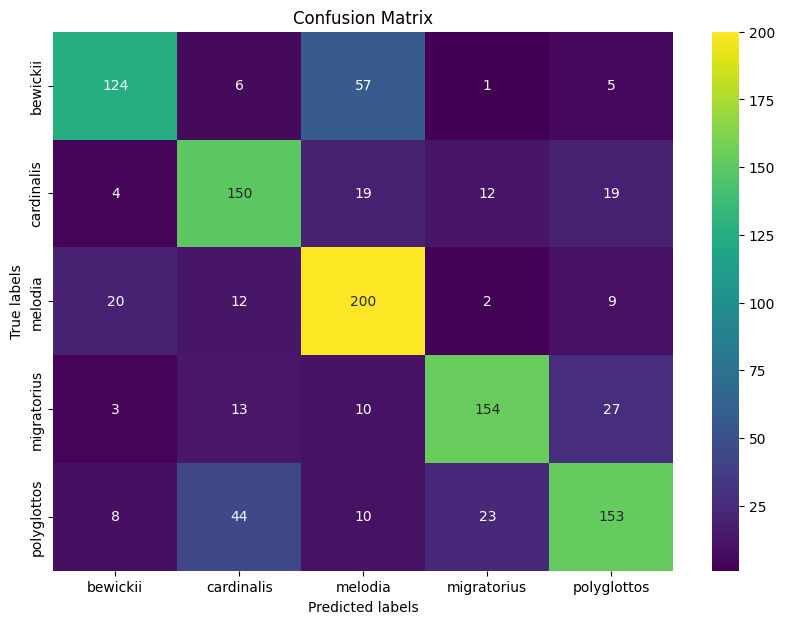

[[124   6  57   1   5]
 [  4 150  19  12  19]
 [ 20  12 200   2   9]
 [  3  13  10 154  27]
 [  8  44  10  23 153]]


In [21]:
cm_Mel = confusion_matrix(y1_test, predictions1)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Mel, annot=True, fmt='g', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_Mel)

In [22]:
# Flatten each element of waveform_features_list
flattened_waveform_features_list = [features.flatten() for features in waveform_features_list]

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(flattened_waveform_features_list, y_encoded, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf_waveform = RandomForestClassifier(random_state=42)

# Train the model
clf_waveform.fit(X2_train, y2_train)

# Prediction
predictions2 = clf_waveform.predict(X2_test)

# Print the accuracy
print(f"Accuracy with waveform features: {accuracy_score(y2_test, predictions2)}")
print(f"Classification Report: {classification_report(y_test, y_pred, target_names=label_encoder.classes_)}\n")


Accuracy with waveform features: 0.7041474654377881
Classification Report:               precision    recall  f1-score   support

    bewickii       0.91      0.89      0.90       193
  cardinalis       0.92      0.91      0.92       204
     melodia       0.87      0.92      0.89       243
 migratorius       0.90      0.96      0.93       207
 polyglottos       0.92      0.83      0.87       238

    accuracy                           0.90      1085
   macro avg       0.90      0.90      0.90      1085
weighted avg       0.90      0.90      0.90      1085




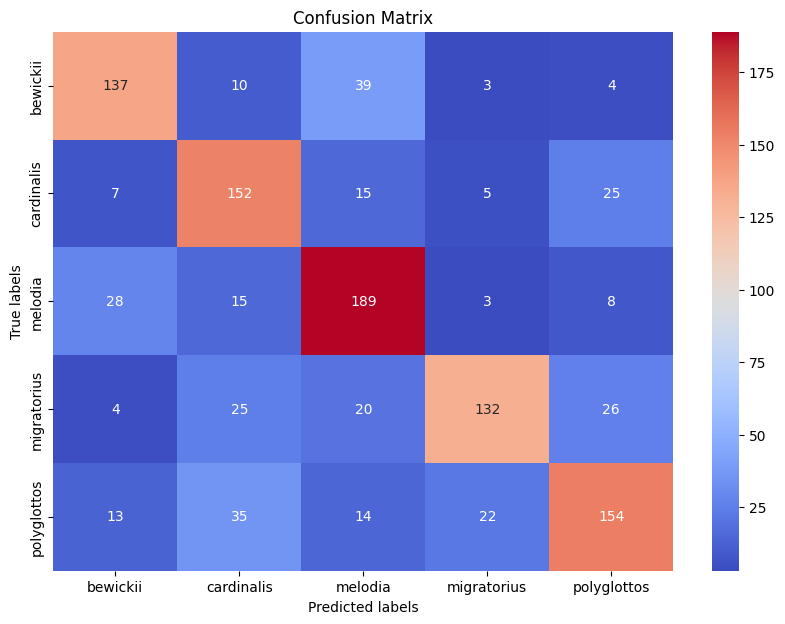

[[137  10  39   3   4]
 [  7 152  15   5  25]
 [ 28  15 189   3   8]
 [  4  25  20 132  26]
 [ 13  35  14  22 154]]


In [23]:
cm_waveform = confusion_matrix(y2_test, predictions2)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_waveform, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm_waveform)

In [32]:
all_features = []
for file_path in file_paths:
    mel_features = extract_log_mel_spectrogram(file_path,sr)
    waveform_features = extract_waveform_features(file_path)
    
    # Ensure both features are flattened
    comb_features = np.concatenate((mel_features.flatten(), waveform_features))
    all_features.append(comb_features)

all_features = np.array(all_features)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

X3_train, X3_test, y3_train, y3_test = train_test_split(all_features, y_encoded, test_size=0.2, random_state=42)
clf_combined = RandomForestClassifier(random_state=42)
clf_combined.fit(X3_train, y3_train)

y3_pred = clf_combined.predict(X3_test)
print(f"Accuracy: {accuracy_score(y3_test, y3_pred)}")
print(f"Classification Report: \n{classification_report(y3_test, y3_pred, target_names=label_encoder.classes_)}\n")

tree_in_forest = clf_combined.estimators_[0]
tree_rules = export_text(tree_in_forest, feature_names=[f"feature_{i}" for i in range(all_features.shape[1])])
print("Rules of the first decision tree:\n", tree_rules)

Accuracy: 0.744700460829493
Classification Report: 
              precision    recall  f1-score   support

    bewickii       0.80      0.66      0.72       193
  cardinalis       0.69      0.77      0.73       204
     melodia       0.69      0.85      0.76       243
 migratorius       0.82      0.74      0.78       207
 polyglottos       0.78      0.68      0.72       238

    accuracy                           0.74      1085
   macro avg       0.75      0.74      0.74      1085
weighted avg       0.75      0.74      0.74      1085


Rules of the first decision tree:
 |--- feature_13016 <= -40.59
|   |--- feature_7943 <= -33.83
|   |   |--- feature_9755 <= -38.32
|   |   |   |--- feature_9015 <= -38.22
|   |   |   |   |--- feature_16805 <= 0.29
|   |   |   |   |   |--- feature_4717 <= -60.96
|   |   |   |   |   |   |--- feature_9110 <= -72.45
|   |   |   |   |   |   |   |--- feature_4140 <= -78.04
|   |   |   |   |   |   |   |   |--- feature_12985 <= -76.10
|   |   |   |   |   |   | 

Model correctly predicts the outcome 74.47% of the time across all classes.

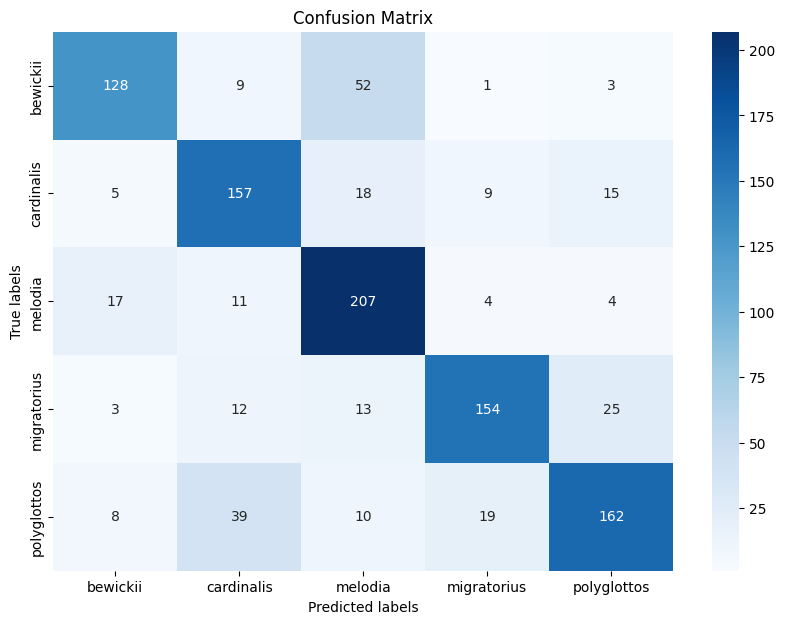

[[128   9  52   1   3]
 [  5 157  18   9  15]
 [ 17  11 207   4   4]
 [  3  12  13 154  25]
 [  8  39  10  19 162]]


In [33]:
cm = confusion_matrix(y3_test, y3_pred)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(cm)

128 instances were correctly predicted as bewickii as bewickii.

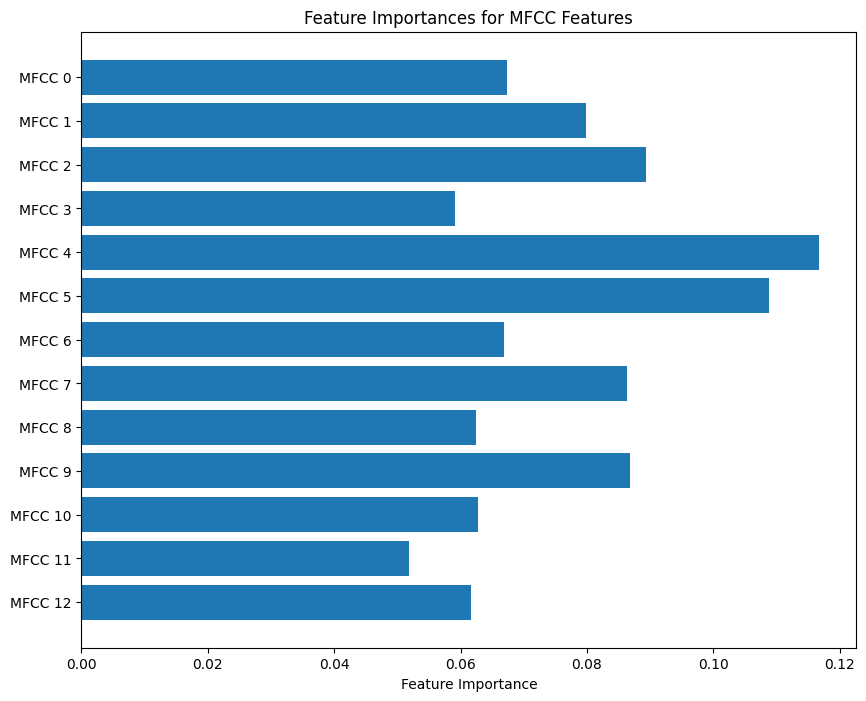

In [49]:
#MFCC
sorted_idx = clf_mfcc.feature_importances_.argsort()
feature_labels = ['MFCC ' + str(i) for i in range(len(clf_mfcc.feature_importances_))]  
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_labels)
plt.xlabel('Feature Importance')
plt.title('Feature Importances for MFCC Features')
plt.gca().invert_yaxis()  
plt.show()


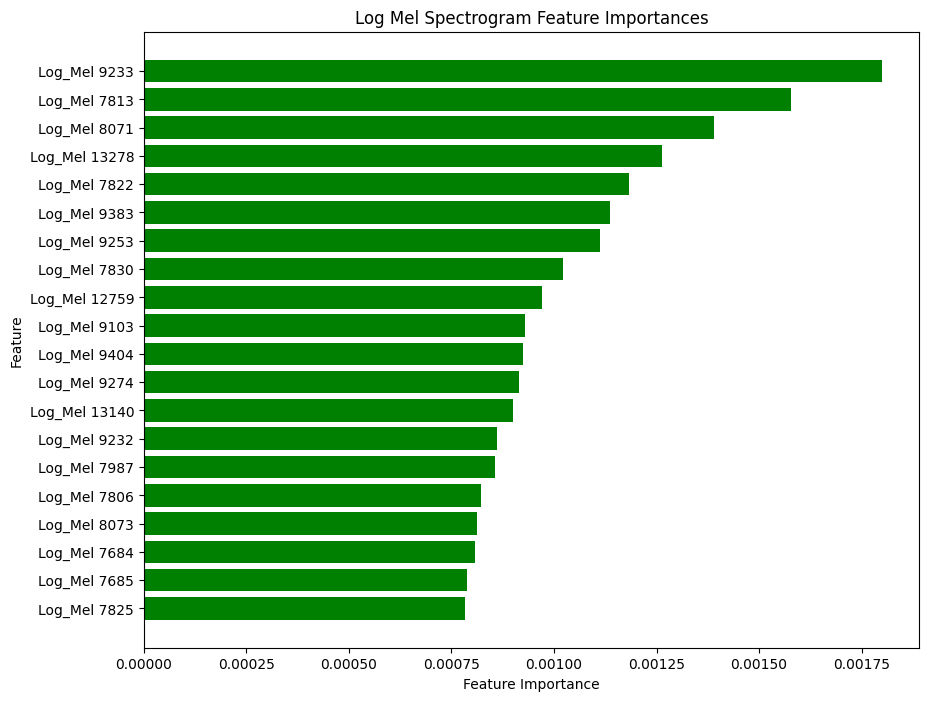

In [42]:
#Log Mel Spectrogram Feature
top_n = 20
sorted_idx = clf_log_Mel.feature_importances_.argsort()[-top_n:]


log_mel_feature_names = [f'Log_Mel {i+1}' for i in range(len(clf_log_Mel.feature_importances_))]


plt.figure(figsize=(10, 8))
plt.barh(range(len(clf_log_Mel.feature_importances_[sorted_idx])), clf_log_Mel.feature_importances_[sorted_idx], color='green')
plt.yticks(range(len(clf_log_Mel.feature_importances_[sorted_idx])), np.array(log_mel_feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Log Mel Spectrogram Feature Importances")
plt.show()


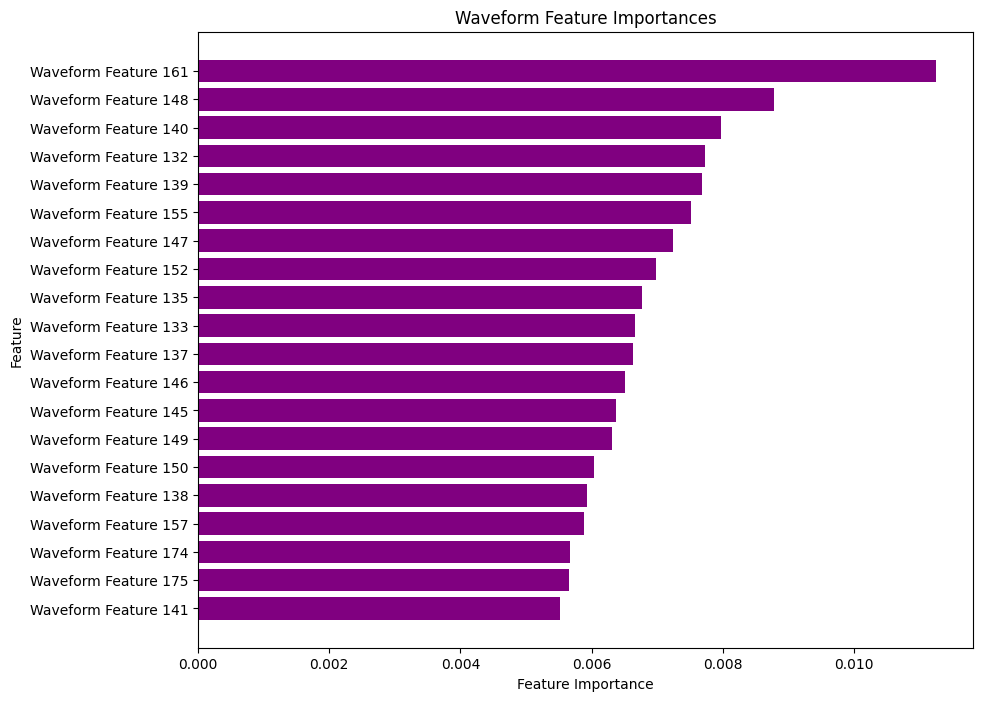

In [43]:
#Waveform Feature Importances
top_n = 20
sorted_idx_waveform = clf_waveform.feature_importances_.argsort()[-top_n:]


waveform_feature_names = [f'Waveform Feature {i+1}' for i in range(len(clf_waveform.feature_importances_))]

plt.figure(figsize=(10, 8))
plt.barh(range(len(clf_waveform.feature_importances_[sorted_idx_waveform])), clf_waveform.feature_importances_[sorted_idx_waveform], color='purple')  # Change to your preferred color
plt.yticks(range(len(clf_waveform.feature_importances_[sorted_idx_waveform])), np.array(waveform_feature_names)[sorted_idx_waveform])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Waveform Feature Importances")
plt.show()


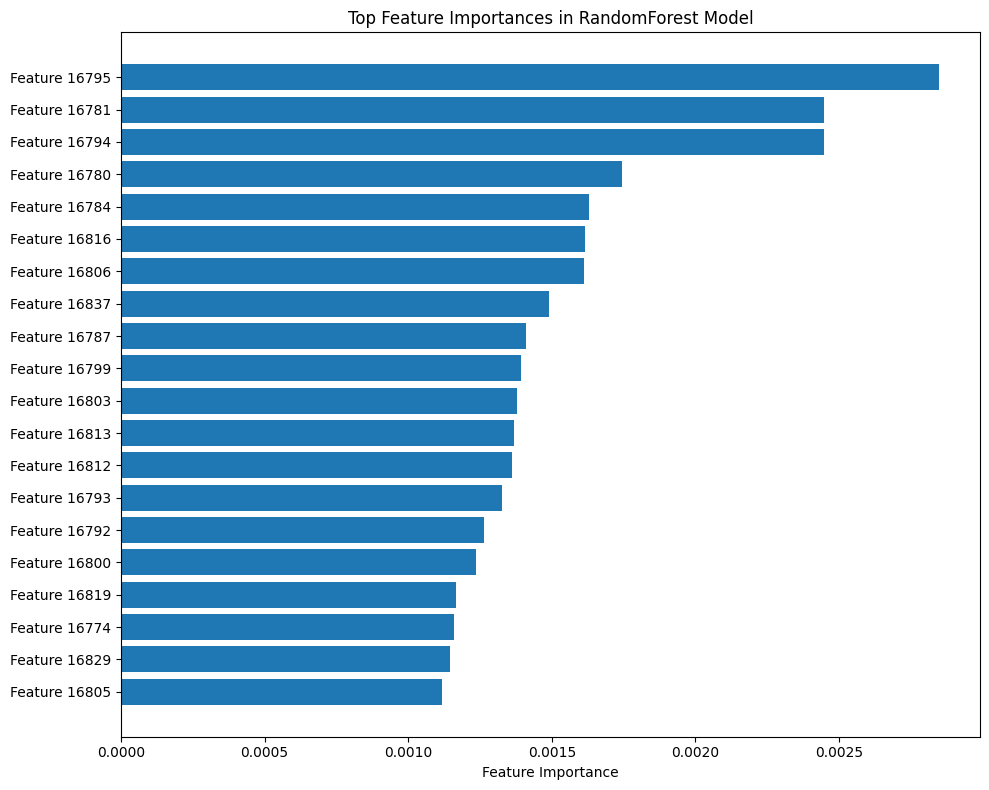

In [37]:
top_n = 20

#feature importances from the model and sorting 
sorted_idx = clf_combined.feature_importances_.argsort()[-top_n:]


plt.figure(figsize=(10, 8))

# feature importances with readable feature names
plt.barh(range(top_n), clf_combined.feature_importances_[sorted_idx], align='center')
plt.yticks(range(top_n), np.array(feature_labels)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances in RandomForest Model')


plt.tight_layout()
plt.show()